<a href="https://colab.research.google.com/github/Rishit605/AI-Art-generation/blob/main/Spatial%20Transformation%20-%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Type 3 - DCGAN Completed - Custom Dataset and Image Size

In [ ]:
import tensorflow as tf
import glob
import PIL
from PIL import Image
import os
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from IPython import display

In [ ]:
!pip install python-dotenv
from dotenv import load_dotenv

In [ ]:
# !touch text.env
load_dotenv()

False

In [ ]:
# # !pip install roboflow

# import os

# api_key = os.getenv("API_KEY")
# secret_key = os.getenv("SECRET_KEY")

# from roboflow import Roboflow
# rf = Roboflow(api_key=api_key)
# project = rf.workspace("majal").project("bird_detection_berkane")
# dataset = project.version(2).download("voc")

!mkdir dataset
%cd dataset

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BE0ifvf11oGilgCsqZFj")
project = rf.workspace("dylog").project("registration-plate-vwtia")
dataset = project.version(3).download("yolov8")



/content/dataset
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=9499bf8c8382675951f813595ce48d59055e9a2d848a2bfd9689b3a6339038d4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall:

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics<=8.0.20`, to intall it `pip install ultralytics<=8.0.20`.

Extracting Dataset Version Zip to Registration-Plate-3 in yolov8:: 100%|██████████| 2966/2966 [00:00<00:00, 4179.99it/s]


In [ ]:
data_path = "/content/dataset/Registration-Plate-3/train/images"

In [ ]:
import os
images = []

for filenames in os.listdir(data_path):
  # if filenames.endswith('jpg'):
    images.append(os.path.join(data_path, filenames))

In [ ]:
import tensorflow as tf

BATCH_SIZE = 4

# Load and preprocess the dataset
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256,256])
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def load_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
    return dataset

train_dataset = load_dataset(images)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 16, 16, 128)

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 32, 32, 64)

  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 64, 64, 32)

  model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 128, 128, 16)

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 256, 256, 3)

  # model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  # assert model.output_shape == (None, 512, 512, 3)

  return model

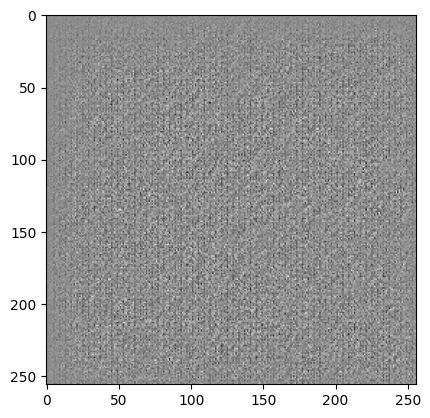

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generated_image.shape

TensorShape([1, 256, 256, 3])

In [ ]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0001273]], shape=(1, 1), dtype=float32)


In [ ]:
decision.shape

TensorShape([1, 1])

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

      noise = tf.random.normal([16, 100])
      generated_images = generator(noise, training=False)
      generated_images = (generated_images * 0.5) + 0.5  # Scale the images to [0, 1]

      # Create a directory to save the generated images
      os.makedirs('generated_images', exist_ok=True)
      for i in range(generated_images.shape[0]):
          tf.keras.preprocessing.image.save_img(f'generated_images/generated_image_{epoch+1}_{i+1}.png',
                                                  generated_images[i])

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
%cd ..
!mkdir output
%cd output

/content
/content/output


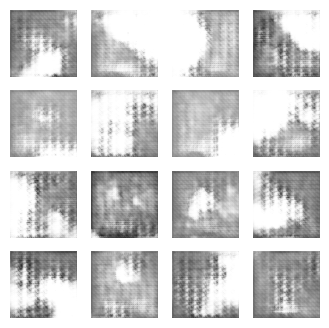

Time for epoch 58 is 9.637262105941772 sec


KeyboardInterrupt: ignored

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint_dir = '/content/GAN_chkpt/content/output/training_checkpoints'

In [ ]:
chkpt = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
chkpt

In [ ]:
import shutil

for filenames in os.listdir('/content'):
  if filenames.endswith('png'):
    shutil.move(filenames, '/content/output')

In [ ]:
generator.save('generator_model.h5')

## Generation

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/output/generator_model.h5')

# Compile the model with the same configurations as before training
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
import numpy as np

num_samples = 5
latent_dim = 100

# Generate random noise
noise = np.random.normal(size=(num_samples, latent_dim))

In [ ]:
generated_images = model.predict(noise)

1/1 [==============================] - 1s 533ms/step


1/1 [==============================] - 0s 20ms/step


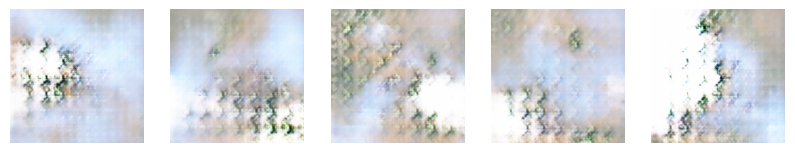

In [ ]:
generated_images = model.predict(noise)

import matplotlib.pyplot as plt

# Rescale pixel values from [-1, 1] to [0, 1]
generated_images = 0.5 * generated_images + 0.5

# Display generated images
fig, axs = plt.subplots(1, num_samples, figsize=(10, 10))
for i in range(num_samples):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')
plt.show()


In [ ]:
! zip -r /content/Custom_GAN_chkpt.zip /content/output/training_checkpoints

  adding: content/output/training_checkpoints/ (stored 0%)
  adding: content/output/training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 8%)
  adding: content/output/training_checkpoints/ckpt-6.data-00000-of-00001 (deflated 9%)
  adding: content/output/training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 8%)
  adding: content/output/training_checkpoints/ckpt-5.index (deflated 70%)
  adding: content/output/training_checkpoints/ckpt-4.index (deflated 70%)
  adding: content/output/training_checkpoints/ckpt-6.index (deflated 70%)
  adding: content/output/training_checkpoints/ckpt-1.data-00000-of-00001 (deflated 9%)
  adding: content/output/training_checkpoints/checkpoint (deflated 38%)
  adding: content/output/training_checkpoints/ckpt-2.index (deflated 70%)
  adding: content/output/training_checkpoints/ckpt-3.index (deflated 70%)
  adding: content/output/training_checkpoints/ckpt-5.data-00000-of-00001 (deflated 8%)
  adding: content/output/training_checkpoints/ckpt-1.index (defl

## **Resume Training**

In [ ]:
!wget https://www.dropbox.com/s/bkz2ib4yomdm313/Custom_GAN_chkpt.zip?dl=0

--2023-07-17 07:35:53--  https://www.dropbox.com/s/bkz2ib4yomdm313/Custom_GAN_chkpt.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bkz2ib4yomdm313/Custom_GAN_chkpt.zip [following]
--2023-07-17 07:35:53--  https://www.dropbox.com/s/raw/bkz2ib4yomdm313/Custom_GAN_chkpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucef92204dd1c1c84ae1cdd89b76.dl.dropboxusercontent.com/cd/0/inline/CACvu_9HH7u19i8F9QHbU5XGgqtKStFCvIZubuOAtQAgbB1Fm6VqB7AcR6rZeoneZseN7mfBFBgR9fGUoEXV07Sor8aqwCFlz_KEXtGwERZlY904016iGwy8p-WGyzOr_jLc-RiZarF4TLKxbv9aYXi_PRcoMGph8S_S4-mjXi7Y_A/file# [following]
--2023-07-17 07:35:53--  https://ucef92204dd1c1c84ae1cdd89b76.dl.dropboxusercontent.com/cd/0/inline/CACvu_9HH7u19i8F9QHbU5XGgqtKStFCvIZubuOAtQAgbB1Fm6V

In [ ]:
!unzip /content/Custom_GAN_chkpt.zip -d /content/GAN_chkpt

Archive:  /content/Custom_GAN_chkpt.zip
   creating: /content/GAN_chkpt/content/output/training_checkpoints/
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-4.data-00000-of-00001  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-6.data-00000-of-00001  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-3.data-00000-of-00001  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-5.index  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-4.index  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-6.index  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-1.data-00000-of-00001  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/checkpoint  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-2.index  
  inflating: /content/GAN_chkpt/content/output/training_checkpoints/ckpt-3.index  
  infla

In [ ]:
import tensorflow as tf

# Load the latest checkpoint file
checkpoint_dir = "/content/GAN_chkpt/content/output/training_checkpoints/ckpt-6.index"
checkpoint_file = tf.train.latest_checkpoint(checkpoint_dir)

# Load the model architecture and weights
model = tf.keras.models.load_model(checkpoint_file)

# Resume training from epoch 10
model.fit(train_dataset, epochs=20, initial_epoch=50)

In [ ]:
new_model = tf.keras.models.load_model('/content/output/generator_model.h5')

# Check its architecture
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_5 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)      819200    
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 128)     

---
# **DCGAN TESTING2**

In [ ]:
import tensorflow as tf
import glob
import PIL
from PIL import Image
import os
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from IPython import display

In [ ]:
!mkdir dataset
%cd dataset

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BE0ifvf11oGilgCsqZFj")
project = rf.workspace("dylog").project("registration-plate-vwtia")
dataset = project.version(3).download("yolov8")

In [ ]:
data_path = "/content/dataset/Registration-Plate-3/train/images"

images = []

for filenames in os.listdir(data_path):
  # if filenames.endswith('jpg'):
    images.append(os.path.join(data_path, filenames))

In [ ]:
BATCH_SIZE = 4

# Load and preprocess the dataset
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256,256])
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def load_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
    return dataset

train_dataset = load_dataset(images)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 16, 16, 128)

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 32, 32, 64)

  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 64, 64, 32)

  model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 128, 128, 16)

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 256, 256, 3)

  # model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  # assert model.output_shape == (None, 512, 512, 3)

  return model

TensorShape([1, 256, 256, 3])

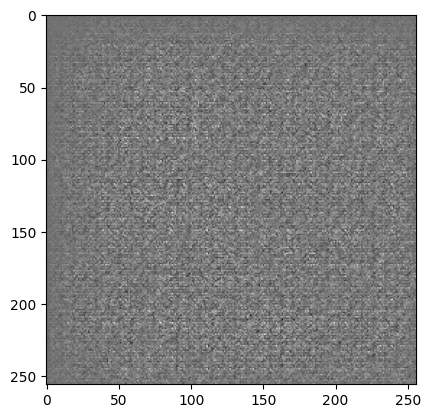

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

generated_image.shape

In [ ]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-2.0084553e-06]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/GAN_chkpt/content/output/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

      noise = tf.random.normal([16, 100])
      generated_images = generator(noise, training=False)
      generated_images = (generated_images * 0.5) + 0.5  # Scale the images to [0, 1]

      # Create a directory to save the generated images
      os.makedirs('generated_images', exist_ok=True)
      for i in range(generated_images.shape[0]):
          tf.keras.preprocessing.image.save_img(f'generated_images/generated_image_{epoch+1}_{i+1}.png',
                                                  generated_images[i])

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
pwd

'/content/output'

In [ ]:
%cd ..
!mkdir output
%cd output

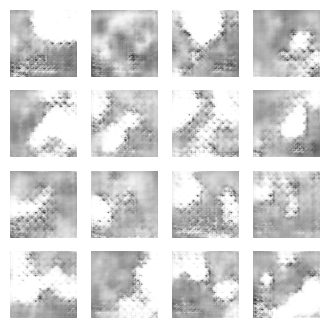

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generator.save('generator_model.h5')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/output/generator_model.h5')

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Compile the model with the same configurations as before training
model.compile(loss=cross_entropy, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
import numpy as np

num_samples = 5
latent_dim = 100

# Generate random noise
noise = np.random.normal(size=(num_samples, latent_dim))

1/1 [==============================] - 1s 563ms/step


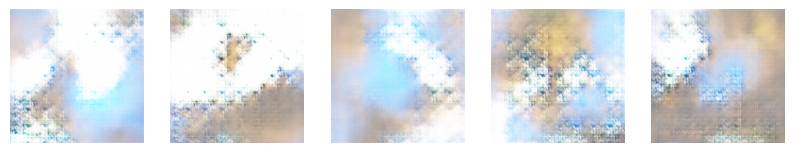

In [ ]:
generated_images = model.predict(noise)

import matplotlib.pyplot as plt

# Rescale pixel values from [-1, 1] to [0, 1]
generated_images = 0.5 * generated_images + 0.5

# Display generated images
fig, axs = plt.subplots(1, num_samples, figsize=(10, 10))
for i in range(num_samples):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')
plt.show()


---

# **Stable Diffusion**

In [ ]:
! pip install tensorflow keras_cv --upgrade --quiet

In [ ]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt


In [ ]:
images = model.text_to_image("aerial view of small metal objects scattered on the Airport runway", batch_size=3)

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
model = keras_cv.models.StableDiffusion()

print("Compute dtype:", model.diffusion_model.compute_dtype)
print(
    "Variable dtype:",
    model.diffusion_model.variable_dtype,
)

In [ ]:
# Warm up model to run graph tracing before benchmarking.
# model.text_to_image("warming up the model", batch_size=3)

start = time.time()
images = model.text_to_image(
    "an assassin standin with his face covered bya black cloth with his back towrads the camrea  with Pyramids of Egypt in background"
    "dull color, high quality, highly detailed, elegant, focus on the assassin, shallow background "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
end = time.time()
# benchmark_result.append(["Mixed Precision", end - start])
plot_images(images)

print(f"Mixed precision model: {(end - start):.2f} seconds")
keras.backend.clear_session()


In [ ]:
plot_images(images)

# **Spactial Transformers** for CNNs and internalized augmented data adaptability


In [1]:
# License: BSD
# Author: Ghassen Hamrouni

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
import glob
from tqdm import tqdm

plt.ion()   # interactive mode

In [3]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

! pip install torchinfo
from torchinfo import summary

In [4]:
!mkdir dataset
%cd dataset

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BE0ifvf11oGilgCsqZFj")
project = rf.workspace("dylog").project("registration-plate-vwtia")
dataset = project.version(3).download("yolov8")

/content/dataset
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=2ca70de1a3a09d54c9d5436c34694f67dd8123714cbe54ba250c31f2d145d854
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall:

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.134`, to intall it `pip install ultralytics==8.0.134`.


Extracting Dataset Version Zip to Registration-Plate-3 in yolov8:: 100%|██████████| 2966/2966 [00:01<00:00, 1691.84it/s]


In [46]:
train_data = '/content/dataset/Registration-Plate-3/train/'
valid_data = '/content/dataset/Registration-Plate-3/valid/'

In [ ]:
## THIS IS OBSOLETE NEWER VERSION IS BELOW ##

class Img_fold(Dataset):
  def __init__(self, tar_dir, transform=None):
    self.paths = tar_dir
    self.transform = transform

  def load_image(self):
    return Image.open(self.paths)

  def __len__(self) -> int:
    for files in os.listdir(self.paths):
      item_path = os.path.join(self.paths, files)

      path_list = []

      if os.path.isfile(item_path) and item_path.endswith(('.jpg', '.png', '.jpeg')):
          path_list.append(item_path)
          return len(path_list)

  def __getitem__(self, idx):
    image = self.load_image(self.paths)

    if self.transform:
      return self.transform(image)
    else:
      return image

In [84]:
imgs = cv2.imread('/content/dataset/Registration-Plate-3/train/images/frame227_jpg.rf.7034f4f9a4d92ec87716a7856cec1c15.jpg', 0)
imgs = cv2.resize(imgs, (128,128))
img_tensor = torch.from_numpy(imgs)
type(img_tensor)

torch.Tensor

In [103]:
class CustomDataset(Dataset):
  def __init__(self, img_dir: str):
    self.img_path = img_dir
    file_list = glob.glob(self.img_path + "*")
    # print(file_list)

    self.data=[]
    for class_path in file_list:
      class_name = "birds"
      for img_path in glob.glob(class_path + "/*.jpg"):
        self.data.append([img_path, class_name])
    # print(self.data)
    self.class_map = {"birds" : 0}
    self.img_dim = (128,128)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path, class_name = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img, self.img_dim)
    # print(img.shape)

    class_id = self.class_map[class_name]
    img_tensor = torch.from_numpy(img)
    img_tensor = img_tensor.permute(2, 0, 1)
    class_id = torch.tensor([class_id])
    return img_tensor.float(), class_id.float()

In [87]:
data_aug = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.ToTensor()
])

In [ ]:
type(train_data)

str

In [104]:
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()
train_dataset = CustomDataset(train_data)

# Training dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)

# Validation Dataset
valid_dataset = CustomDataset(valid_data)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,
                                           num_workers=NUM_WORKERS)

In [75]:
train_loader

In [105]:
for imgs, labels in train_loader:
    print("Batch of images has shape: ",imgs.shape, type(imgs))
    print("Batch of labels has shape: ", labels.shape, type(labels))

Batch of images has shape:  torch.Size([4, 3, 128, 128]) <class 'torch.Tensor'>
Batch of labels has shape:  torch.Size([4, 1]) <class 'torch.Tensor'>
Batch of images has shape:  torch.Size([4, 3, 128, 128]) <class 'torch.Tensor'>
Batch of labels has shape:  torch.Size([4, 1]) <class 'torch.Tensor'>
Batch of images has shape:  torch.Size([4, 3, 128, 128]) <class 'torch.Tensor'>
Batch of labels has shape:  torch.Size([4, 1]) <class 'torch.Tensor'>
Batch of images has shape:  torch.Size([4, 3, 128, 128]) <class 'torch.Tensor'>
Batch of labels has shape:  torch.Size([4, 1]) <class 'torch.Tensor'>
Batch of images has shape:  torch.Size([4, 3, 128, 128]) <class 'torch.Tensor'>
Batch of labels has shape:  torch.Size([4, 1]) <class 'torch.Tensor'>
Batch of images has shape:  torch.Size([4, 3, 128, 128]) <class 'torch.Tensor'>
Batch of labels has shape:  torch.Size([4, 1]) <class 'torch.Tensor'>
Batch of images has shape:  torch.Size([4, 3, 128, 128]) <class 'torch.Tensor'>
Batch of labels has 

In [43]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 252270616.63it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22407638.52it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 206007905.53it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15822698.31it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [91]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [52]:
images.shape

torch.Size([4, 3, 128, 128])

In [53]:
c1 = nn.Conv2d(3, 10, 5)
p1 = nn.MaxPool2d(2, 2)
d1 = nn.Dropout2d()
c2 = nn.Conv2d(10, 20, 5)

x = c1(images)
x = p1(x)
x = c2(x)
x = p1(x)
# x = d1(x)
x.shape

torch.Size([4, 20, 29, 29])

In [ ]:
## THis is for GrayScale Images

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [ ]:
summary(model, input_size=(4, 3, 128, 128))

In [106]:
## For testing the Output Image shapes after Convolution
c1 = nn.Conv2d(3, 32, 7)
p1 = nn.MaxPool2d(2, 2)
d1 = nn.ReLU()
c2 = nn.Conv2d(32, 64, 5)

x = c1(images)
x = p1(x)
x = d1(x)
x = c2(x)
x = p1(x)
x = d1(x)
x.shape

TypeError: ignored

In [ ]:
## This is for RGB images.

class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()
        # simple convnet classifier
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*29*29, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84,1)

        # spatial transformer localization network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
        )
        # tranformation regressor for theta
        self.fc_loc = nn.Sequential(
            nn.Linear(64*28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )
        # initializing the weights and biases with identity transformations
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0],
                                                    dtype=torch.float))
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1)*xs.size(2)*xs.size(3))
        # calculate the transformation parameters theta
        theta = self.fc_loc(xs)
        # resize theta
        theta = theta.view(-1, 2, 3)
        # grid generator => transformation on parameters theta
        grid = F.affine_grid(theta, x.size())
        # grid sampling => applying the spatial transformations
        x = F.grid_sample(x, grid)
        return x
    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # forward pass through the classifier
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = STN().to(device)
summary(model, input_size=(4, 3, 128, 128))

In [123]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train_step(model, dataloader,
              loss_fn, optimizer,
              device=device):

  model.train()

  train_loss, trian_acc = 0, 0

  for batch, (images, labels)  in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    y_pred = model(images)

    loss_fn = criterion(y_pred, labels)
    train_loss += loss_fn.item()

    loss_fn.backward()

    optimizer.step()

    _, preds = torch.max(y_pred.images, 1)
    train_acc += (preds == labels).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

def test_step(model, dataloader,
              loss_fn, optimizer,
              device=device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (images, labels) in enumerate(valid_loader):
      images, labels = images.to(device), labels.to(device)

      y_test_pred = model(images)

      loss_fn = criterion(y_test_pred, labels)
      test_loss +=  loss_fn.item()

      _, test_preds = torch.max(y_test_pred.images, 1)
      test_acc += (test_preds == labels).sum().item()/len(y_test_pred)

    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

In [124]:
def transform_to_numpy(image_grid, epoch):
    """
    This function transforms the PyTorch image grids
    into NumPy format that we will denormalize and save
    as PNG file.
    """
    image_grid = image_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_grid = std * image_grid + mean
    return image_grid

In [125]:
images = []
def stn_grid(epoch):
    """
    This function will pass one batch of the test
    image to the STN model and get the transformed images
    after each epoch to save as PNG file and also as
    GIFFY file.
    """
    with torch.no_grad():
        data = next(iter(valid_loader))[0].to(device)
        transformed_image = model.stn(data).cpu().detach()
        image_grid = torchvision.utils.make_grid(transformed_image)
        # save the grid image
        image_grid = transform_to_numpy(image_grid, epoch)
        plt.imshow(image_grid)
        plt.savefig(f"../outputs/image_{epoch}.png")
        plt.close()
        images.append(image_grid)

In [127]:
# train for certain epochs

epochs = 40

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    train_loss, train_acc = train_step(model, train_loader,
                                       optimizer, criterion)

    test_loss, test_acc = test_step(model, valid_loader,
                                    optimizer, criterion)
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}")
    stn_grid(epoch)

Epoch 1 of 40


Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.


AttributeError: ignored

## RGB Fin~

---

## GrayScale Cont-

In [42]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [43]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 5 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.


Train Epoch: 1 [0/1024 (0%)]	Loss: -0.000000


KeyboardInterrupt: ignored